In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import lightgbm as lgb

sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)

sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')

plt.rcParams["figure.figsize"] = [15, 5]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%matplotlib inline

In [20]:
# Read data
data = pd.read_pickle('20231108_Dataset_Processed.pkl')
data.head()

,transformer_load,radiation,windspeed_10m,windspeed_100m,windspeed_squall,nedu_e1a,nedu_e1b,nedu_e1c,nedu_e2a,nedu_e2b,...,day_of_year_cos,transformer_load_lag_2days,transformer_load_lag_5days,transformer_load_lag_7days,windspeed_100m_3h_mean,windspeed_100m_1d_mean,windspeed_squall_3h_mean,windspeed_squall_1d_mean,radiation_3h_mean,radiation_1d_mean
Date,,,,,,,,,,,,,,,,,,,,,
2021-04-09 10:15:00+00:00,0.655497,2.139711e+06,6.068184,7.706377,10.432041,0.000022,0.000016,0.000012,0.000030,0.000026,...,-0.133015,0.860733,0.149738,0.314834,7.856740,8.482728,10.248645,8.407537,1.700433e+06,780098.818258
2021-04-09 10:30:00+00:00,0.676091,2.240682e+06,6.103702,7.747967,10.514462,0.000022,0.000015,0.000011,0.000030,0.000025,...,-0.133015,0.897033,0.159860,0.455148,7.846817,8.470331,10.310933,8.393179,1.777003e+06,782144.193583
2021-04-09 10:45:00+00:00,0.660384,2.341653e+06,6.141287,7.791777,10.601013,0.000021,0.000014,0.000011,0.000029,0.000024,...,-0.133015,0.907155,0.178360,0.492845,7.834948,8.457775,10.364110,8.378342,1.853714e+06,783613.980855
2021-04-09 11:00:00+00:00,0.660035,2.442624e+06,6.180901,7.837771,10.691594,0.000020,0.000013,0.000010,0.000029,0.000024,...,-0.133015,0.932984,0.172775,0.479581,7.819994,8.445067,10.406397,8.363042,1.930565e+06,784508.180074
2021-04-09 11:15:00+00:00,0.687260,2.466027e+06,6.159403,7.807181,10.734140,0.000019,0.000012,0.000009,0.000029,0.000024,...,-0.133015,0.929145,0.180803,0.512740,7.805399,8.434417,10.449004,8.348299,2.006537e+06,785131.799703


In [21]:
# Splitting the dataset into train, validation, and test sets
train_size = 0.75
val_size = 0.15
test_size = 0.10

# First split to separate out the test set
train_val, test = train_test_split(data, test_size=test_size, shuffle=False)

# Second split to separate out the validation set
train, val = train_test_split(train_val, test_size=test_size/(train_size + val_size), shuffle=False)

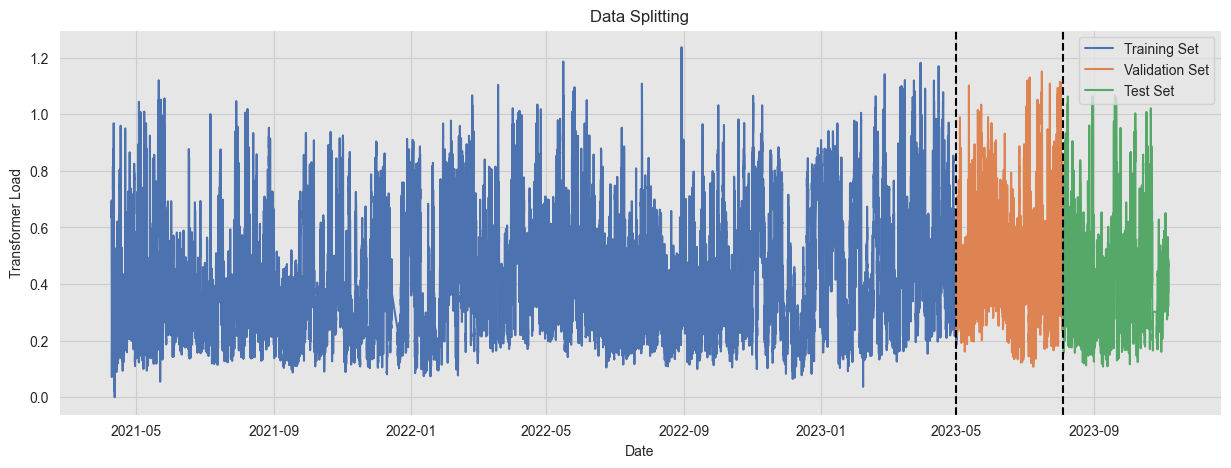

In [22]:
fig, ax = plt.subplots()

# Plotting the data
sns.lineplot(data=train['transformer_load'], ax=ax, label='Training Set', color=sns_c[0])
sns.lineplot(data=val['transformer_load'], ax=ax, label='Validation Set', color=sns_c[1])
sns.lineplot(data=test['transformer_load'], ax=ax, label='Test Set', color=sns_c[2])

# Adding vertical lines for the start of validation and test sets
ax.axvline(val.index[0], color='black', ls='--')
ax.axvline(test.index[0], color='black', ls='--')

# Setting up the legend and titles
ax.legend()
plt.title('Data Splitting')
plt.xlabel('Date')
plt.ylabel('Transformer Load')
plt.show()

In [23]:
# Initial hyperparameters
lgb_params = {
    'objective': 'quantile',
    'metric': 'quantile',
    'boosting_type': 'gbdt',
    'seed': 42,
    'learning_rate': 0.1,
    'num_leaves': 16,
    'max_depth': -1,
    'min_data_in_leaf': 20,
    'min_gain_to_split': 0,
    'bagging_fraction': 0.9,
    'bagging_freq': 1,
    'feature_fraction': 0.9,
    'lambda_l1': 0.01,
    'lambda_l2': 0.01,
    'force_col_wise': 'true'
}

In [24]:
# Preparing the data for LightGBM
target = 'transformer_load'
train_data = lgb.Dataset(train.drop(columns=['transformer_load']), label=train['transformer_load'])
val_data = lgb.Dataset(val.drop(columns=['transformer_load']), label=val['transformer_load'])
test_data = lgb.Dataset(test.drop(columns=['transformer_load']), label=test['transformer_load'])

In [25]:
# Training models for each quantile
quantiles = [0.05, 0.5, 0.95]
models = {}

for quantile in quantiles:
    print(f"Training model for quantile: {quantile}")
    lgb_params['alpha'] = quantile
    model = lgb.train(lgb_params,
                      train_data, 
                      num_boost_round=400,
                      valid_sets=[train_data, val_data], 
                      callbacks=[lgb.early_stopping(stopping_rounds=40), lgb.log_evaluation(50)]
                      )
    models[quantile] = model

Training model for quantile: 0.05
[LightGBM] [Info] Total Bins 6536
[LightGBM] [Info] Number of data points in the train set: 71560, number of used features: 30
[LightGBM] [Info] Start training from score 0.161955
Training until validation scores don't improve for 40 rounds


KeyboardInterrupt: 

In [ ]:
# Making predictions on the train, validation, and test sets for upper, median, and lower quantiles
train_preds_lower = models[0.05].predict(train.drop(columns=['transformer_load']))
train_preds = models[0.5].predict(train.drop(columns=['transformer_load']))
train_preds_upper = models[0.95].predict(train.drop(columns=['transformer_load']))

val_preds_lower = models[0.05].predict(val.drop(columns=['transformer_load']))
val_preds = models[0.5].predict(val.drop(columns=['transformer_load']))
val_preds_upper = models[0.95].predict(val.drop(columns=['transformer_load']))

test_preds_lower = models[0.05].predict(test.drop(columns=['transformer_load']))
test_preds = models[0.5].predict(test.drop(columns=['transformer_load']))
test_preds_upper = models[0.95].predict(test.drop(columns=['transformer_load']))

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

# Calculating MAE, RMSE, MAPE, MASE, and mdRAE
metrics = {}
for split, actual, predicted in [('Train', train['transformer_load'], train_preds),
                                 ('Validation', val['transformer_load'], val_preds),
                                 ('Test', test['transformer_load'], test_preds)]:
    
    r2 = r2_score(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = mean_absolute_percentage_error(actual, predicted)

    metrics[split] = [r2, mae, rmse, mape]

In [ ]:
# Converting the metrics to a DataFrame for better visualization
metrics_df = pd.DataFrame(metrics, index=['R2', 'MAE', 'RMSE', 'MAPE']).T
metrics_df.rename_axis('Split', inplace=True)
metrics_df.reset_index(inplace=True)
metrics_df['Model'] = 'Baseline'
metrics_df.set_index(['Model', 'Split'], inplace=True)

metrics_df

In [ ]:
def plot_actual_vs_predicted(datasets, predictions, titles, x_label='Actual', y_label='Predicted'):
    """
    Plots actual values against predictions with ideal diagonal lines for each dataset.

    :param datasets: List of datasets containing the actual values.
    :param predictions: List of predictions corresponding to each dataset.
    :param titles: List of titles for each subplot.
    :param x_label: Label for the x-axis.
    :param y_label: Label for the y-axis.
    """
    # Number of datasets
    n_datasets = len(datasets)

    # Setting up the plot
    fig, axes = plt.subplots(nrows=1, ncols=n_datasets, figsize=(5 * n_datasets, 8))

    # Looping through datasets and predictions to create each subplot
    for i in range(n_datasets):
        sns.scatterplot(x=datasets[i]['transformer_load'], y=predictions[i], ax=axes[i], s=10)
        
        # Adding an ideal (diagonal) line
        max_val = max(datasets[i]['transformer_load'].max(), max(predictions[i]))
        axes[i].plot([0, max_val], [0, max_val], color='red', lw=2, linestyle='--')

        # Adding titles and labels
        axes[i].set_title(titles[i])
        axes[i].set_xlabel(x_label)
        axes[i].set_ylabel(y_label)
    
    fig.suptitle("Actual vs Predicted Transformer Load", fontsize=16)
    plt.tight_layout()

# Example usage for train, val, and test sets
plot_actual_vs_predicted(
    [train, val, test], 
    [train_preds, val_preds, test_preds], 
    ["Train Set", "Validation Set", "Test Set"]
)

In [ ]:
def calculate_errors(dataset, predictions):
    """
    Calculates errors between the actual values and predictions.
    :param dataset: The dataset containing the actual values.
    :param predictions: The predicted values.
    :return: A Series containing the errors.
    """
    return predictions - dataset['transformer_load']

# Calculating errors for each dataset
train_errors = calculate_errors(train, train_preds)
val_errors = calculate_errors(val, val_preds)
test_errors = calculate_errors(test, test_preds)

# Creating a DataFrame for plotting
error_data = pd.DataFrame({
    'Error': pd.concat([train_errors, val_errors, test_errors]),
    'Dataset': ['Train'] * len(train_errors) + ['Validation'] * len(val_errors) + ['Test'] * len(test_errors)
})

# Plotting errors using seaborn's violinplot
plt.figure(figsize=(10, 6))
sns.violinplot(x='Dataset', y='Error', data=error_data, hue='Dataset')
plt.title('Error Distribution Across Train, Validation, and Test Sets')
plt.show()

In [ ]:
import plotly.graph_objects as go

def plot_predictions_with_confidence_interval(dataset, preds_lower, preds, preds_upper, title):
    """
    Plots the real transformer_load vs predicted transformer_load with 90% confidence interval.

    :param dataset: The dataset containing the real transformer_load.
    :param preds_lower: Predictions for the lower bound (5th percentile).
    :param preds: Median predictions (50th percentile).
    :param preds_upper: Predictions for the upper bound (95th percentile).
    :param title: Title of the plot.
    """
    # Creating a Plotly figure
    fig = go.Figure()

    # Adding the real transformer load
    fig.add_trace(go.Scatter(
        x=dataset.index, y=dataset['transformer_load'], 
        mode='lines', name='Actual', 
        line=dict(color='blue')
    ))

    # Adding the predicted transformer load
    fig.add_trace(go.Scatter(
        x=dataset.index, y=preds, 
        mode='lines', name='Predicted', 
        line=dict(color='red')
    ))

    # Adding the lower bound of the confidence interval
    fig.add_trace(go.Scatter(
        x=dataset.index, y=preds_lower, 
        mode='lines', line=dict(width=0), 
        showlegend=False
    ))

    # Adding the upper bound of the confidence interval and filling the area
    fig.add_trace(go.Scatter(
        x=dataset.index, y=preds_upper, 
        mode='lines', line=dict(width=0), 
        fill='tonexty', fillcolor='rgba(255, 0, 0, 0.2)', 
        name='90% confidence interval'
    ))

    # Adding layout specifications
    fig.update_layout(
        title={
            'text': f'<b>{title}<b>',
            'y': 0.9,
            'x': 0.5,
            'xanchor': 'center',
            'yanchor': 'top',
            'font': {'size': 20, 'color': 'black', 'family': "Arial, sans-serif"}
        },
 
        xaxis_title='Date',
        yaxis_title='Transformer Load',
        hovermode="x unified"
    )

    return fig

In [ ]:
days_15 = 15 * 96
plot_predictions_with_confidence_interval(
    test[0:days_15], 
    test_preds_lower[0:days_15],
    test_preds[0:days_15], 
    test_preds_upper[0:days_15], 
    "Short-term Forecasting of Transformer Load (1st 15 Days of Test Set)"
)

In [ ]:
plot_predictions_with_confidence_interval(
    test[-days_15:-1], 
    test_preds_lower[-days_15:-1],
    test_preds[-days_15:-1], 
    test_preds_upper[-days_15:-1], 
    "Short-term Forecasting of Transformer Load (Last 15 Days of Test Set)"
)